# Linear Regression Extension

w207 section 3 - Ben Meier

## Import modules, data

In [ ]:
import os
import random

import numpy as np
import pandas as pd
from google.colab import drive, files

import matplotlib.pyplot as plt
import seaborn as sns


# sklearn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

# Set value_counts(dropna=False)
print(pd.Series.value_counts.__annotations__)
pd.Series.value_counts.__defaults__ = (False, True, False, None, False)

{'normalize': 'bool', 'sort': 'bool', 'ascending': 'bool', 'dropna': 'bool'}


In [ ]:
try:
    import sweetviz
except:
    !pip install sweetviz
    import sweetviz

In [ ]:
# Connect notebook to google drive W207 - Final Project Folder
drive.mount('/content/drive')

path = r'/content/drive/MyDrive/W207 - Final Project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = pd.read_pickle('/content/drive/MyDrive/W207 - Final Project/pickles/dffinal_multihot_train.pk1')
test = pd.read_pickle('/content/drive/MyDrive/W207 - Final Project/pickles/dffinal_multihot_test.pk1')
train.head()

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Other,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane,WGT_Low-e,roof_Shingles,roof_Built-up,roof_Slate or tile shingles,roof_Metal surfacing,roof_Other Or Combination,roof_Asphalt/fiberglass/other shingles,roof_Wood shingles/shakes/other wood,roof_Plastic/rubber/synthetic sheeting,roof_Green Roof,cool_Central AC,cool_No cooling,cool_Other,cool_Cooling_Heat Pump,cool_Split AC,heat_Boiler,heat_Resistance Heating,heat_Heating_Heat pump,heat_Other,heat_Heating_Furnace,wall_Other,wall_wall_Wood,wall_wall_Metal,wall_wall_Brick_stone,wall_wall_Concrete
0,0.548814,austin,100012,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.656706,0.0,28.656706,89.982058,3.565981,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.715189,austin,100012,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.493681,0.0,29.493681,92.610158,3.670133,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.602763,austin,100030,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,37.971292,0.0,37.971292,119.229858,4.725069,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.544883,austin,100030,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,39.017660,0.0,39.017660,122.515452,4.855277,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.423655,austin,100138,2014.0,2A Hot - Humid (Houston-TX),Commercial,NaN,62368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,32.005873,NaN,NaN,NaN,NaN,"Austin, TX 78704",1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Data Preprocessing

### Fix mixed column types

In [ ]:
train.insert(0, 'df', 'train')
test.insert(0, 'df', 'test')
df = pd.concat([train, test])

In [ ]:
bad_col_types = []
for col in df.columns:
    weird = (df[[col]].applymap(type) != df[[col]].iloc[0].apply(type)).any(axis=1)
    if len(df[weird]) > 0:
        bad_col_types.append(col)
        print(col, "Na values:", df[col].isna().sum())

id Na values: 0
climate Na values: 823
facility_type Na values: 156941
heating Na values: 295828
cooling Na values: 145377
wall_type Na values: 295626
roof_ceiling Na values: 142155
window_glass_layers Na values: 294400
window_glass_type Na values: 296012
energy_star_label Na values: 291654
city_line Na values: 20484


In [ ]:
for col in bad_col_types:
    df[col] = df[col].apply(lambda x: pd.NA if pd.isnull(x) else str(x))

In [ ]:
df.isnull().sum()

df                                             0
rand_num                                       0
datasource                                     0
id                                             0
year                                           0
climate                                      823
building_class                                 0
facility_type                             156941
floor_area                                     0
year_built                                  4779
heating                                   295828
cooling                                   145377
wall_type                                 295626
roof_ceiling                              142155
window_glass_layers                       294400
window_glass_type                         296012
energy_star_label                         291654
energy_star_rating                        206522
electric_eui                               95099
fuel_eui                                  135265
site_eui            

### Feature Engineering

In [ ]:
df_engr = df.copy()
df_engr.sample(5)

,df,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Other,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane,WGT_Low-e,roof_Shingles,roof_Built-up,roof_Slate or tile shingles,roof_Metal surfacing,roof_Other Or Combination,roof_Asphalt/fiberglass/other shingles,roof_Wood shingles/shakes/other wood,roof_Plastic/rubber/synthetic sheeting,roof_Green Roof,cool_Central AC,cool_No cooling,cool_Other,cool_Cooling_Heat Pump,cool_Split AC,heat_Boiler,heat_Resistance Heating,heat_Heating_Heat pump,heat_Other,heat_Heating_Furnace,wall_Other,wall_wall_Wood,wall_wall_Metal,wall_wall_Brick_stone,wall_wall_Concrete
29953,train,0.928333,chicago,159980,2019.0,5A Cool - Humid (Chicago-IL),Residential,Multifamily - Uncategorized,106000.0,1967.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,55.0,10.191676,92.904301,103.095977,129.551380,6.524756,"Chicago, IL 60649",0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
214505,train,0.406801,nycOrdinance,1021360200,2013.0,4A Mixed - Humid (Baltimore-MD),Residential,Multifamily - Uncategorized,64214.0,1922.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,119.435614,148.874963,NaN,"New York, NY 10032",0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
122258,train,0.510924,gainesville,149224,2015.0,2A Hot - Humid (Houston-TX),Residential,<NA>,1554.0,1983.0,<NA>,Central Air Conditioning,<NA>,Asphalt/fiberglass/other shingles,<NA>,<NA>,<NA>,NaN,NaN,15.251313,NaN,NaN,NaN,"Gainesville, FL 32606",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
242397,test,0.982865,nycOrdinance,4050057502,2015.0,4A Mixed - Humid (Baltimore-MD),Residential,Multifamily - Uncategorized,111100.0,1924.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,89.0,NaN,NaN,76.605711,101.508803,NaN,"Flushing, NY 11354",0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
203061,test,0.080417,nycOrdinance,1011387501,2015.0,4A Mixed - Humid (Baltimore-MD),Residential,Multifamily - Uncategorized,159018.0,1995.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1.0,NaN,NaN,241.277155,490.862991,NaN,"New York, NY 10023",0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Binarize building_class

In [ ]:
df_engr.building_class.drop_duplicates()

0    Residential
4     Commercial
Name: building_class, dtype: object

In [ ]:
repl = {'Residential': 1.0,
        'Commercial': 0.0}
df_engr['is_residential'] = df_engr.building_class.replace(repl)
df_engr['is_residential'] = df_engr.is_residential.astype('uint8')
df_engr[['is_residential', 'building_class']].drop_duplicates()

,is_residential,building_class
0,1,Residential
4,0,Commercial


### Has Energy Star Label

In [ ]:
df_engr['energy_star_label'].drop_duplicates()

0               <NA>
8892         Labeled
15641    Not Labeled
Name: energy_star_label, dtype: object

In [ ]:
repl = {'Labeled': 1.0,
        'Not Labeled': 0.0}
df_engr['has_energy_star_label'] = df_engr.energy_star_label.replace(repl)
df_engr[['has_energy_star_label', 'energy_star_label']].drop_duplicates()

,has_energy_star_label,energy_star_label
0,<NA>,<NA>
8892,1.0,Labeled
15641,0.0,Not Labeled


#### Humidity, Temp

In [ ]:
def split_climate(dfin):
        
    fn = lambda x: pd.NA if isinstance(x,  type(pd.NA)) else x.split(" - ")[1].split(" ")[0] if isinstance(x, str) else pd.NA
    dfin['dryness'] = dfin.climate.apply(fn)

    fn = lambda x: pd.NA if isinstance(x,  type(pd.NA)) else x.split(" - ")[0].split(" ")[1] if isinstance(x, str) else pd.NA
    dfin['temp'] = dfin.climate.apply(fn)

    return dfin

In [ ]:
df_engr = split_climate(df_engr)

In [ ]:
df_engr = pd.concat([df_engr.drop(columns=['dryness', 'temp']),
                     pd.get_dummies(df_engr.temp, prefix='temp', dummy_na=True),
                     pd.get_dummies(df_engr.dryness, prefix='dryness', dummy_na=True)
                    ], axis=1)

#### Building Age

In [ ]:
df_engr['age'] = df_engr.year - df_engr.year_built


In [ ]:
df_engr.sample(7)

,df,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Other,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane,WGT_Low-e,roof_Shingles,roof_Built-up,roof_Slate or tile shingles,roof_Metal surfacing,roof_Other Or Combination,roof_Asphalt/fiberglass/other shingles,roof_Wood shingles/shakes/other wood,roof_Plastic/rubber/synthetic sheeting,roof_Green Roof,cool_Central AC,cool_No cooling,cool_Other,cool_Cooling_Heat Pump,cool_Split AC,heat_Boiler,heat_Resistance Heating,heat_Heating_Heat pump,heat_Other,heat_Heating_Furnace,wall_Other,wall_wall_Wood,wall_wall_Metal,wall_wall_Brick_stone,wall_wall_Concrete,is_residential,has_energy_star_label,temp_Cold,temp_Cool,temp_Hot,temp_Mixed,temp_Warm,temp_nan,dryness_Dry,dryness_Humid,dryness_Marine,dryness_nan,age
266664,train,0.608428,seattle,21338,2019.0,4C Mixed - Marine (Salem-OR),Residential,2-4 Unit Building,24840.0,1905.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,90.0,16.672507,12.718478,29.390986,65.706075,2.101401,"Seattle, WA 98104",0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,0,0,0,1,0,0,0,0,1,0,114.0
222332,train,0.282614,nycOrdinance,2033190107,2017.0,4A Mixed - Humid (Baltimore-MD),Residential,Multifamily - Uncategorized,60366.0,1926.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,47.0,NaN,NaN,122.000000,160.800000,NaN,"Bronx, NY 10468",0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,0,0,0,1,0,0,0,1,0,0,91.0
144956,test,0.399884,gainesville,154554,2011.0,2A Hot - Humid (Houston-TX),Residential,<NA>,1718.0,2000.0,<NA>,Central Air Conditioning,<NA>,Asphalt/fiberglass/other shingles,<NA>,<NA>,<NA>,NaN,NaN,14.435720,NaN,NaN,NaN,"Gainesville, FL 32608",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,0,0,1,0,0,0,0,1,0,0,11.0
116614,train,0.473474,gainesville,147731,2012.0,2A Hot - Humid (Houston-TX),Residential,<NA>,1291.0,1968.0,<NA>,Central Air Conditioning,<NA>,Built-up,<NA>,<NA>,<NA>,NaN,20.098159,25.467209,45.565369,89.848791,4.377304,"Gainesville, FL 32609",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,0,0,1,0,0,0,0,1,0,0,44.0
80749,test,0.453825,gainesville,138535,2011.0,2A Hot - Humid (Houston-TX),Residential,<NA>,1180.0,1984.0,<NA>,Central Air Conditioning,<NA>,Asphalt/fiberglass/other shingles,<NA>,<NA>,<NA>,NaN,9.478839,8.556784,17.229151,37.901382,1.880522,"Gainesville, FL 32606",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,0,0,1,0,0,0,0,1,0,0,27.0
169121,train,0.701932,gainesville,161527,2012.0,2A Hot - Humid (Houston-TX),Residential,<NA>,1131.0,1979.0,<NA>,Central Air Conditioning,<NA>,Asphalt/fiberglass/other shingles,<NA>,<NA>,<NA>,NaN,44.526574,NaN,NaN,NaN,NaN,<NA>,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,0,0,1,0,0,0,0,1,0,0,33.0
214251,test,0.716063,nycOrdinance,1021190036,2014.0,4A Mixed - Humid (Baltimore-MD),Residential,Multifamily - Uncategorized,135070.0,1983.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,45.0,NaN,NaN,85.348952,126.714952,NaN,"New York, NY 10032",0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,0,0,0,1,0,0,0,1,0,0,31.0


### Drop NA Site_EUI

In [ ]:
# Split back into train/test
df_engr_train = df_engr.loc[df_engr.df == 'train', :].copy()
df_engr_test = df_engr.loc[df_engr.df == 'test', :].copy()

In [ ]:
print("Shape of train:", df_engr_train.shape, "test:", df_engr_test.shape)
print("Missing site_eui from train:", df_engr_train.site_eui.isna().sum(), "from test:", df_engr_test.site_eui.isna().sum())

print("Drop Site_EUI NAN:")
train_dropna = df_engr_train.loc[df_engr_train.site_eui.isna() != 1, :]
test_dropna = df_engr_test.loc[df_engr_test.site_eui.isna() != 1, :]

print("Shape of train:", train_dropna.shape, "test:", test_dropna.shape)
print("Missing site_eui from train:", train_dropna.site_eui.isna().sum(), "from test:", test_dropna.site_eui.isna().sum())
train_dropna.sample(5)

Shape of train: (187002, 89) test: (109063, 89)
Missing site_eui from train: 59407 from test: 32448
Drop Site_EUI NAN:
Shape of train: (127595, 89) test: (76615, 89)
Missing site_eui from train: 0 from test: 0


,df,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Other,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane,WGT_Low-e,roof_Shingles,roof_Built-up,roof_Slate or tile shingles,roof_Metal surfacing,roof_Other Or Combination,roof_Asphalt/fiberglass/other shingles,roof_Wood shingles/shakes/other wood,roof_Plastic/rubber/synthetic sheeting,roof_Green Roof,cool_Central AC,cool_No cooling,cool_Other,cool_Cooling_Heat Pump,cool_Split AC,heat_Boiler,heat_Resistance Heating,heat_Heating_Heat pump,heat_Other,heat_Heating_Furnace,wall_Other,wall_wall_Wood,wall_wall_Metal,wall_wall_Brick_stone,wall_wall_Concrete,is_residential,has_energy_star_label,temp_Cold,temp_Cool,temp_Hot,temp_Mixed,temp_Warm,temp_nan,dryness_Dry,dryness_Humid,dryness_Marine,dryness_nan,age
163795,train,0.206336,gainesville,160125,2013.0,2A Hot - Humid (Houston-TX),Residential,<NA>,1530.0,1965.0,<NA>,Central Air Conditioning,<NA>,Asphalt/fiberglass/other shingles,<NA>,<NA>,<NA>,NaN,27.957885,22.810978,49.984531,110.915737,5.277820,"Gainesville, FL 32603",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,0,0,1,0,0,0,0,1,0,0,48.0
19891,train,0.239773,calProp,19644856013015,2012.0,3B Warm - Dry (El Paso-TX),Commercial,Education - Elementary or middle school,87940.0,NaN,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,16.991673,1.116670,18.108344,54.526359,1.533661,"Whittier, CA 90604",0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,<NA>,0,0,0,0,1,0,1,0,0,0,NaN
226776,train,0.409079,nycOrdinance,3010280056,2016.0,4A Mixed - Humid (Baltimore-MD),Residential,Multifamily - Uncategorized,18000.0,1914.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,28.0,NaN,NaN,149.191257,178.411202,NaN,"Brooklyn, NY 11215",0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,0,0,0,1,0,0,0,1,0,0,102.0
94408,train,0.497278,gainesville,142054,2014.0,2A Hot - Humid (Houston-TX),Residential,<NA>,2645.0,1991.0,<NA>,Central Air Conditioning,<NA>,Asphalt/fiberglass/other shingles,<NA>,<NA>,<NA>,NaN,30.789945,23.365373,57.633658,124.866326,5.849315,"Gainesville, FL 32608",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,0,0,1,0,0,0,0,1,0,0,23.0
207542,train,0.777345,nycOrdinance,1013860064,2015.0,4A Mixed - Humid (Baltimore-MD),Residential,Multifamily - Uncategorized,113068.0,1929.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN,NaN,87.167926,134.550632,NaN,"New York, NY 10021",0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,0,0,0,1,0,0,0,1,0,0,86.0


### SweetViz

In [ ]:
train_dropna.site_eui.describe()

count    127595.000000
mean         64.742619
std          56.407862
min           1.002456
25%          32.305466
50%          51.446028
75%          80.975918
max         997.866120
Name: site_eui, dtype: float64

In [ ]:
train_dropna.isna().sum()

df                                             0
rand_num                                       0
datasource                                     0
id                                             0
year                                           0
climate                                      479
building_class                                 0
facility_type                              43727
floor_area                                     0
year_built                                  2727
heating                                   127563
cooling                                    85046
wall_type                                 127253
roof_ceiling                               83464
window_glass_layers                       126732
window_glass_type                         127571
energy_star_label                         124212
energy_star_rating                         71970
electric_eui                               40778
fuel_eui                                   43037
site_eui            

In [ ]:
# Create SweetViz
target = 'site_eui'
cols = [col for col in train_dropna.columns 
        if col not in ['electric_eui', 'fuel_eui', 'source_eui', 'ghg_emissions_int']]

path_rpt = path + 'output_ben/LR Raw Report.html'
rpt  = sweetviz.compare(
    [train_dropna[cols], "Training"],
    [test_dropna[cols], "Test"],
    target_feat=target)
rpt.show_html(path_rpt)

files.download(path_rpt)

Check for duplicates:

In [ ]:
pks = ['datasource', 'id', 'year']
train_dropna.value_counts(pks, dropna=False)

datasource    id          year  
austin        100012      2018.0    1
nycOrdinance  1019760013  2017.0    1
              1019770041  2016.0    1
              1019770034  2016.0    1
              1019770033  2016.0    1
                                   ..
gainesville   139092      2013.0    1
                          2012.0    1
                          2011.0    1
              139091      2014.0    1
syracuse      99          2017.0    1
Length: 127595, dtype: int64

In [ ]:
test_dropna.value_counts(pks, dropna=False)

datasource    id          year  
austin        100409      2018.0    1
nycOrdinance  1012900056  2011.0    1
              1012900044  2016.0    1
                          2015.0    1
                          2014.0    1
                                   ..
gainesville   141433      2011.0    1
              141431      2014.0    1
                          2013.0    1
                          2012.0    1
syracuse      83          2017.0    1
Length: 76615, dtype: int64

### DFs Ready for Models

In [ ]:
y = train_dropna[['site_eui']].copy()
y_test = test_dropna[['site_eui']].copy()

X = train_dropna.drop(columns=['site_eui', 'df']).copy()
X_test = test_dropna.drop(columns=['site_eui', 'df']).copy()
X.sample(5)

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,source_eui,ghg_emissions_int,city_line,clim_2A Hot - Humid,clim_3C Warm - Marine,clim_5A Cool - Humid,clim_3B Warm - Dry,clim_2B Hot - Dry,clim_4C Mixed - Marine,clim_6B Cold - Dry,clim_4B Mixed - Dry,clim_5B Cool - Dry,clim_4A Mixed - Humid,clim_6A Cold - Humid,clim_3A Warm - Humid,BC_Residential,BC_Commercial,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Other,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane,WGT_Low-e,roof_Shingles,roof_Built-up,roof_Slate or tile shingles,roof_Metal surfacing,roof_Other Or Combination,roof_Asphalt/fiberglass/other shingles,roof_Wood shingles/shakes/other wood,roof_Plastic/rubber/synthetic sheeting,roof_Green Roof,cool_Central AC,cool_No cooling,cool_Other,cool_Cooling_Heat Pump,cool_Split AC,heat_Boiler,heat_Resistance Heating,heat_Heating_Heat pump,heat_Other,heat_Heating_Furnace,wall_Other,wall_wall_Wood,wall_wall_Metal,wall_wall_Brick_stone,wall_wall_Concrete,is_residential,has_energy_star_label,temp_Cold,temp_Cool,temp_Hot,temp_Mixed,temp_Warm,temp_nan,dryness_Dry,dryness_Humid,dryness_Marine,dryness_nan,age
165405,0.184726,gainesville,160557,2010.0,2A Hot - Humid (Houston-TX),Residential,<NA>,1478.0,1995.0,<NA>,Central Air Conditioning,<NA>,Asphalt/fiberglass/other shingles,<NA>,<NA>,<NA>,NaN,NaN,14.276375,104.394966,5.287179,"Gainesville, FL 32605",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,0,0,1,0,0,0,0,1,0,0,15.0
145188,0.169489,gainesville,154625,2012.0,2A Hot - Humid (Houston-TX),Residential,<NA>,2991.0,2001.0,<NA>,Central Air Conditioning,<NA>,Asphalt/fiberglass/other shingles,<NA>,<NA>,<NA>,NaN,13.358843,15.361487,57.635800,2.800035,"Gainesville, FL 32606",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,0,0,1,0,0,0,0,1,0,0,11.0
271993,0.805354,seattle,25149,2017.0,4C Mixed - Marine (Salem-OR),Residential,5+ Unit Building,36765.0,1967.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,31.0,38.242503,0.000000,120.081459,3.301319,"Seattle, WA 98118",0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,0,0,0,1,0,0,0,0,1,0,50.0
217856,0.885759,nycOrdinance,2025510065,2017.0,4A Mixed - Humid (Baltimore-MD),Residential,Multifamily - Uncategorized,32034.0,1920.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,14.0,NaN,NaN,189.800000,NaN,"Bronx, NY 10454",0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,0,0,0,1,0,0,0,1,0,0,97.0
208679,0.295285,nycOrdinance,1014457501,2017.0,4A Mixed - Humid (Baltimore-MD),Residential,Multifamily - Uncategorized,340286.0,1961.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,46.0,NaN,NaN,109.100000,NaN,"New York, NY 10021",0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,<NA>,0,0,0,1,0,0,0,1,0,0,56.0


## Model Functions

In [ ]:
def linear_model(X, y, num_features, 
                 normalize=False,
                 learning_rate=0.001, batch=32, epochs=15):
    """Build a TF linear regression model using Keras.
    """

    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # single layer sequential for linear reg
    model = tf.keras.Sequential()

    if normalize:
        norm = tf.keras.layers.Normalization()
        norm.adapt(X)
        norm_mean = norm.mean.numpy()
        norm_var = norm.variance.numpy()

        model.add(norm)

    model.add(tf.keras.layers.Dense(
        units=1,                     # output dim
        input_shape=[num_features],  # input dim
        use_bias=True,               # use a bias (intercept) param
    ))

    # Compile, specify MSE as loss 
    model.compile(loss='mse', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
                  metrics = ['MAE', 'MAPE'])
    
    print(model.summary())

    history = model.fit(x=X, y=y, 
                        validation_split=0.1, 
                        batch_size=12, 
                        epochs=epochs)
    
    return model, history

In [ ]:
def linear_plot(X, model, history, 
                loss_ylim=200_000, mae_ylim=200, mape_ylim=200):
    """Plots emtrics for linear regression"""
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.set_ylim(0,loss_ylim)

    ax = fig.add_subplot(1, 3, 2)
    ax.plot(x_arr, hist['MAE'], '-o', label='Train MAE')
    ax.plot(x_arr, hist['val_MAE'], '--<', label='Validation MAE')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('MeanAbsoluteError', size=15)
    ax.set_ylim(0,mae_ylim)

    ax = fig.add_subplot(1, 3, 3)
    ax.plot(x_arr, hist['MAPE'], '-o', label='Train MAPE')
    ax.plot(x_arr, hist['val_MAPE'], '--<', label='Validation MAPE')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('MeanAbsolutePercentageError', size=15)
    ax.set_ylim(0,mape_ylim)

    plt.show()
        
    # Show the final train loss value and the learned model weights.
    print('Final val loss:', round(list(history.history['val_loss'])[-1], 2))
    print('Final val mean absolute error:', round(list(history.history['val_MAE'])[-1], 2))
    print('Final val mean absolute percentage error:', round(list(history.history['val_MAPE'])[-1], 2))
    print('Final bias:', round(model.layers[0].get_weights()[1].flatten()[0], 2))
    for col, val in zip(X.columns, model.layers[0].get_weights()[0].flatten().tolist()):
        print(col, round(val, 4))
    return None


## Baseline Model
Features: age, floor_area, energy_star_rating, is_residential

Baseline model with just one row for each building (most recent)


In [ ]:
# Identify continuous variables
cols = ['age', 'floor_area', 'energy_star_rating', 'is_residential']
baseline = X[cols].copy()
print("shape:", baseline.shape)
baseline.describe()

shape: (127595, 4)


,age,floor_area,energy_star_rating,is_residential
count,124868.000000,1.275950e+05,55625.000000,127595.000000
mean,47.665166,1.022971e+05,61.404422,0.675489
std,32.447077,1.993315e+05,29.074337,0.468194
min,0.000000,5.000000e+02,1.000000,0.000000
25%,21.000000,2.110000e+03,40.000000,0.000000
50%,41.000000,5.294400e+04,68.000000,1.000000
75%,72.000000,1.114765e+05,86.000000,1.000000
max,367.000000,6.385382e+06,100.000000,1.000000


In [ ]:
# Deal with NANs
missing = baseline.isna().any(axis=1)
print("Rows with missing values:", missing.sum())

baseline = baseline[~missing]
baseline_y = y[~missing]
pd.concat([baseline, baseline_y]).sample(5)

Rows with missing values: 72695


,age,floor_area,energy_star_rating,is_residential,site_eui
266012,NaN,NaN,NaN,NaN,34.497987
255797,107.0,67460.0,12.0,0.0,NaN
25847,NaN,NaN,NaN,NaN,60.005214
224065,76.0,69734.0,75.0,1.0,NaN
246536,12.0,78894.0,57.0,0.0,NaN


### Fit model

In [ ]:
baseline_model, baseline_history = linear_model(
    baseline, baseline_y, 
    num_features=baseline.shape[1],
    epochs=15)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
4118/4118 [==============================] - 7s 2ms/step - loss: 4147452160.0000 - MAE: 20997.5156 - MAPE: 40209.7695 - val_loss: 5533.7080 - val_MAE: 56.1455 - val_MAPE: 131.0619
Epoch 2/25
4118/4118 [==============================] - 8s 2ms/step - loss: 7529.5649 - MAE: 67.6204 - MAPE: 186.0019 - val_loss: 5053.9146 - val_MAE: 52.7149 - val_MAPE: 122.0158
Epoch 3/25
4118/4118 [==============================] - 7s 2ms/step - loss: 6287.1719 - MAE: 59.5684 - MAPE: 159.6319 - val_loss: 3663.8054 - val_MAE: 43.3602 - val_MAPE: 96.2381
Epoch 4/25
4118/4118 [=============

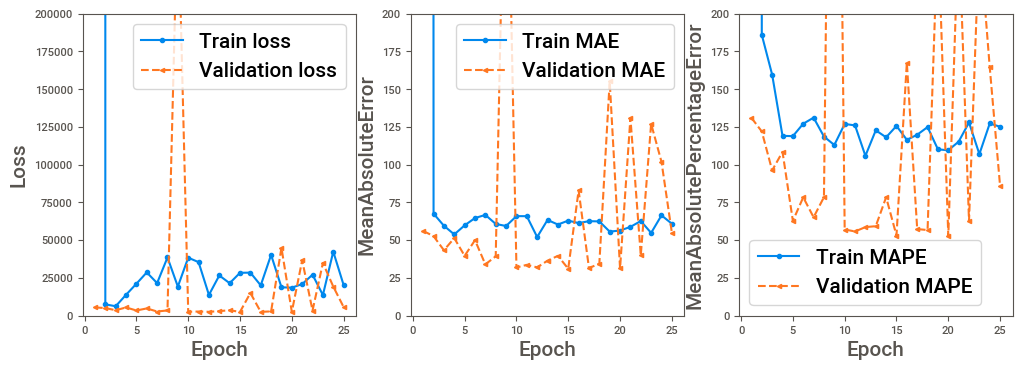

Final val loss: 5731.94
Final val mean absolute error: 55.03
Final val mean absolute percentage error: 85.83
Final bias: 15.2
age 0.69
floor_area -0.0
energy_star_rating -0.13
is_residential 11.63


In [ ]:
linear_plot(baseline, baseline_model, baseline_history)

## Linear Model - multihot

- Idenfity MH columns
- Drop 'other' columns for multicollinearity
- Dropped columns with excessive NAs:
    - 'has_energy_star_label', 'energy_star_rating'

In [ ]:
# Identify columns of interest
cols = ['is_residential', 'floor_area', 'age', 
    # Dropped due to excessive NAs: 'has_energy_star_label', 'energy_star_rating',
    'FT_Multifamily', 'FT_Industrial', 'FT_Office', 'FT_Retail', 'FT_Hotel', 'FT_Restaurant', 
    'FT_Grocery', 'FT_Hospital', 'FT_Data Center', 'FT_Singlefamily', # 'FT_Other', 
    'WGL_Single-pane', 'WGL_Double-pane', 'WGT_Low-e',  # There are ton's of 'missing' for this column
    'roof_Shingles', 'roof_Built-up', 'roof_Slate or tile shingles', 'roof_Metal surfacing', 
    'roof_Asphalt/fiberglass/other shingles', 'roof_Wood shingles/shakes/other wood', 
    'roof_Plastic/rubber/synthetic sheeting', 'roof_Green Roof', # 'roof_Other Or Combination', 
    'cool_Central AC', 'cool_No cooling', 'cool_Cooling_Heat Pump', 'cool_Split AC',  # 'cool_Other',
    'heat_Boiler', 'heat_Resistance Heating', 'heat_Heating_Heat pump', 'heat_Heating_Furnace',  # 'heat_Other', 
    'wall_wall_Metal', 'wall_wall_Brick_stone', 'wall_wall_Concrete', 'wall_wall_Wood', # 'wall_Other', 
    'temp_Cold', 'temp_Cool', 'temp_Hot', 'temp_Mixed', 'temp_Warm', #'temp_nan', 
    'dryness_Dry', 'dryness_Humid', 'dryness_Marine', #'dryness_nan'
    ]

In [ ]:
lm_mh = X[cols].copy()
print("shape:", lm_mh.shape)
lm_mh.describe()

shape: (127595, 44)


,is_residential,floor_area,age,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane,WGT_Low-e,roof_Shingles,roof_Built-up,roof_Slate or tile shingles,roof_Metal surfacing,roof_Asphalt/fiberglass/other shingles,roof_Wood shingles/shakes/other wood,roof_Plastic/rubber/synthetic sheeting,roof_Green Roof,cool_Central AC,cool_No cooling,cool_Cooling_Heat Pump,cool_Split AC,heat_Boiler,heat_Resistance Heating,heat_Heating_Heat pump,heat_Heating_Furnace,wall_wall_Metal,wall_wall_Brick_stone,wall_wall_Concrete,wall_wall_Wood,temp_Cold,temp_Cool,temp_Hot,temp_Mixed,temp_Warm,dryness_Dry,dryness_Humid,dryness_Marine
count,127595.000000,1.275950e+05,124868.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.0,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000,127595.000000
mean,0.675489,1.022971e+05,47.665166,0.000259,0.007257,0.005713,0.044242,0.320091,0.190015,0.011450,0.002359,0.037204,0.002680,0.001136,0.005627,0.000188,0.316384,0.016403,0.0,0.002273,0.000149,0.006999,0.000627,0.000031,0.323469,0.000031,0.000008,0.000016,0.000165,0.000024,0.000031,0.000024,0.000047,0.000259,0.000674,0.000415,0.001121,0.122011,0.354363,0.446742,0.072009,0.025808,0.835197,0.135240
std,0.468194,1.993315e+05,32.447077,0.016080,0.084881,0.075371,0.205632,0.466513,0.392315,0.106392,0.048513,0.189261,0.051703,0.033692,0.074803,0.013714,0.465066,0.127022,0.0,0.047620,0.012202,0.083365,0.025032,0.005599,0.467802,0.005599,0.002800,0.003959,0.012828,0.004849,0.005599,0.004849,0.006857,0.016080,0.025953,0.020377,0.033459,0.327300,0.478322,0.497157,0.258504,0.158563,0.371004,0.341982
min,0.000000,5.000000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.110000e+03,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,5.294400e+04,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,1.114765e+05,72.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,6.385382e+06,367.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000

In [ ]:
lm_mh.isna().sum()

is_residential                               0
floor_area                                   0
age                                       2727
FT_Multifamily                               0
FT_Industrial                                0
FT_Office                                    0
FT_Retail                                    0
FT_Hotel                                     0
FT_Restaurant                                0
FT_Grocery                                   0
FT_Hospital                                  0
FT_Data Center                               0
FT_Singlefamily                              0
WGL_Single-pane                              0
WGL_Double-pane                              0
WGT_Low-e                                    0
roof_Shingles                                0
roof_Built-up                                0
roof_Slate or tile shingles                  0
roof_Metal surfacing                         0
roof_Asphalt/fiberglass/other shingles       0
roof_Wood shi

In [ ]:
lm_mh

,is_residential,floor_area,age,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane,WGT_Low-e,roof_Shingles,roof_Built-up,roof_Slate or tile shingles,roof_Metal surfacing,roof_Asphalt/fiberglass/other shingles,roof_Wood shingles/shakes/other wood,roof_Plastic/rubber/synthetic sheeting,roof_Green Roof,cool_Central AC,cool_No cooling,cool_Cooling_Heat Pump,cool_Split AC,heat_Boiler,heat_Resistance Heating,heat_Heating_Heat pump,heat_Heating_Furnace,wall_wall_Metal,wall_wall_Brick_stone,wall_wall_Concrete,wall_wall_Wood,temp_Cold,temp_Cool,temp_Hot,temp_Mixed,temp_Warm,dryness_Dry,dryness_Humid,dryness_Marine
0,1,160356.0,5.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,1,160356.0,6.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,1,51195.0,36.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,1,51195.0,37.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
6,1,5158.0,22.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296060,0,69230.0,57.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
296061,0,69230.0,58.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
296062,0,69230.0,59.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
296063,0,50163.0,56.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [ ]:
# Deal with NANs
print("Rows:", lm_mh.shape[0])
missing = lm_mh.isna().any(axis=1)
print("Rows with missing values:", missing.sum())

Rows: 127595
Rows with missing values: 2727


In [ ]:
print("Missing values by column:")
for col in lm_mh.columns:
    nas = lm_mh[col].isnull().sum()
    if nas != 0:
        print(col, nas)

Missing values by column:
age 2727


In [ ]:
lm_mh = lm_mh[~missing]
lm_mh_y = y[~missing]
print("Final size:", lm_mh.shape[0])
pd.concat([lm_mh, lm_mh_y], axis=1).sample(5)

Final size: 124868


,is_residential,floor_area,age,FT_Multifamily,FT_Industrial,FT_Office,FT_Retail,FT_Hotel,FT_Restaurant,FT_Grocery,FT_Hospital,FT_Data Center,FT_Singlefamily,WGL_Single-pane,WGL_Double-pane,WGT_Low-e,roof_Shingles,roof_Built-up,roof_Slate or tile shingles,roof_Metal surfacing,roof_Asphalt/fiberglass/other shingles,roof_Wood shingles/shakes/other wood,roof_Plastic/rubber/synthetic sheeting,roof_Green Roof,cool_Central AC,cool_No cooling,cool_Cooling_Heat Pump,cool_Split AC,heat_Boiler,heat_Resistance Heating,heat_Heating_Heat pump,heat_Heating_Furnace,wall_wall_Metal,wall_wall_Brick_stone,wall_wall_Concrete,wall_wall_Wood,temp_Cold,temp_Cool,temp_Hot,temp_Mixed,temp_Warm,dryness_Dry,dryness_Humid,dryness_Marine,site_eui
123874,1,2312.0,36.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,34.452903
174961,1,1392.0,35.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,26.732995
84783,1,2256.0,42.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,46.032024
85829,1,1052.0,33.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,54.073972
234922,1,128160.0,60.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,75.991803


### Fit model

In [ ]:
mh_model, mh_history = linear_model(
    lm_mh, lm_mh_y, 
    num_features=lm_mh.shape[1],
    batch=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 45        
                                                                 
Total params: 45
Trainable params: 45
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
9366/9366 [==============================] - 16s 2ms/step - loss: 23775828.0000 - MAE: 500.1418 - MAPE: 1088.3533 - val_loss: 4832.8667 - val_MAE: 40.5390 - val_MAPE: 72.5917
Epoch 2/15
9366/9366 [==============================] - 18s 2ms/step - loss: 34841.4727 - MAE: 54.5358 - MAPE: 126.4630 - val_loss: 5203.0532 - val_MAE: 44.8090 - val_MAPE: 83.9225
Epoch 3/15
9366/9366 [==============================] - 15s 2ms/step - loss: 22129.8398 - MAE: 47.9527 - MAPE: 118.1991 - val_loss: 5107.5991 - val_MAE: 43.2429 - val_MAPE: 98.1967
Epoch 4/15
9366/9366 [=============

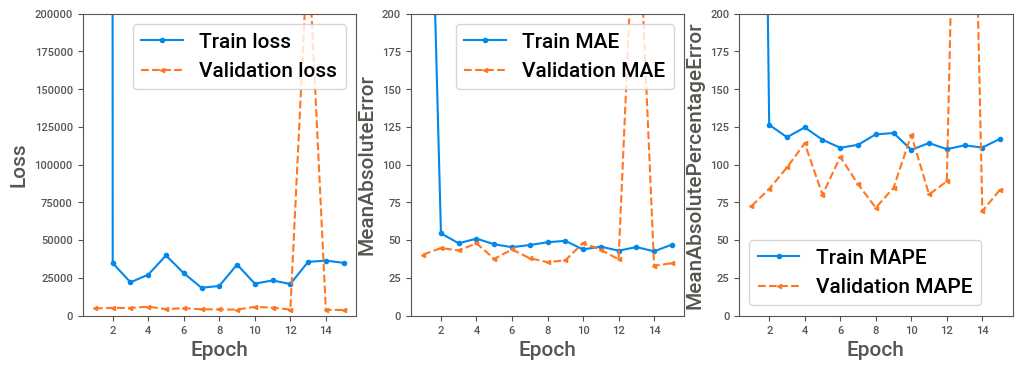

Final val loss: 3766.35
Final val mean absolute error: 34.79
Final val mean absolute percentage error: 83.5
Final bias: 13.3
is_residential 5.24
floor_area 0.0
age 0.42
FT_Multifamily 4.88
FT_Industrial 27.16
FT_Office 11.72
FT_Retail 14.07
FT_Hotel 5.97
FT_Restaurant 5.23
FT_Grocery 16.91
FT_Hospital 12.92
FT_Data Center 9.59
FT_Singlefamily 5.29
WGL_Single-pane -1.64
WGL_Double-pane -6.6
WGT_Low-e -2.02
roof_Shingles 0.33
roof_Built-up -5.14
roof_Slate or tile shingles 0.24
roof_Metal surfacing -0.58
roof_Asphalt/fiberglass/other shingles 1.2
roof_Wood shingles/shakes/other wood -2.08
roof_Plastic/rubber/synthetic sheeting -1.89
roof_Green Roof -1.27
cool_Central AC -0.88
cool_No cooling 0.21
cool_Cooling_Heat Pump 0.29
cool_Split AC -0.15
heat_Boiler 0.23
heat_Resistance Heating 0.73
heat_Heating_Heat pump 0.1
heat_Heating_Furnace 0.87
wall_wall_Metal -0.78
wall_wall_Brick_stone 2.6
wall_wall_Concrete -0.01
wall_wall_Wood -0.11
temp_Cold 3.89
temp_Cool 14.92
temp_Hot -4.97
temp_Mixe

In [ ]:
linear_plot(lm_mh, mh_model, mh_history)

## Linear Model - normalized

In [ ]:
lm_mh.shape

(124868, 44)

### Fit model
learning_rate=0.001

In [ ]:
mh_norm_model, mh_norm_history = linear_model(
    lm_mh, lm_mh_y, 
    num_features=lm_mh.shape[1],
    normalize=True,
    batch=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 44)               89        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 45        
                                                                 
Total params: 134
Trainable params: 45
Non-trainable params: 89
_________________________________________________________________
None
Epoch 1/15
9366/9366 [==============================] - 17s 2ms/step - loss: 6375.0869 - MAE: 60.4408 - MAPE: 100.3607 - val_loss: 6634.2314 - val_MAE: 56.4846 - val_MAPE: 81.3593
Epoch 2/15
9366/9366 [==============================] - 17s 2ms/step - loss: 5091.8149 - MAE: 52.5786 - MAPE: 96.9700 - val_loss: 5904.9458 - val_MAE: 50.7050 - val_MAPE: 77.6413
Epoch 3/15
9366/9366 [==

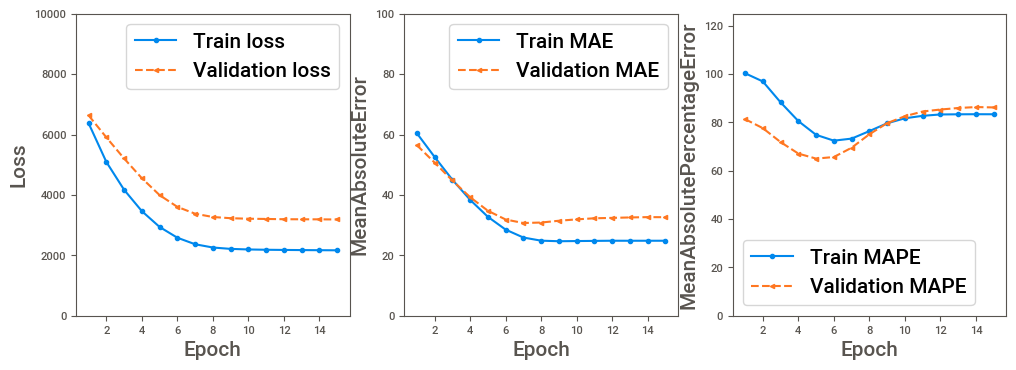

Final val loss: 3186.99
Final val mean absolute error: 32.62
Final val mean absolute percentage error: 86.21
Final bias: 0.22
is_residential 0.686
floor_area 101674.2656
age 47.6652
FT_Multifamily 0.0003
FT_Industrial 0.0073
FT_Office 0.0056
FT_Retail 0.0442
FT_Hotel 0.3233
FT_Restaurant 0.1804
FT_Grocery 0.0113
FT_Hospital 0.0024
FT_Data Center 0.037
FT_Singlefamily 0.0027
WGL_Single-pane 0.0012
WGL_Double-pane 0.0058
WGT_Low-e 0.0002
roof_Shingles 0.3233
roof_Built-up 0.0168
roof_Slate or tile shingles 0.0
roof_Metal surfacing 0.0023
roof_Asphalt/fiberglass/other shingles 0.0002
roof_Wood shingles/shakes/other wood 0.0071
roof_Plastic/rubber/synthetic sheeting 0.0006
roof_Green Roof 0.0
cool_Central AC 0.3305
cool_No cooling 0.0
cool_Cooling_Heat Pump 0.0
cool_Split AC 0.0
heat_Boiler 0.0002
heat_Resistance Heating 0.0
heat_Heating_Heat pump 0.0
heat_Heating_Furnace 0.0
wall_wall_Metal 0.0
wall_wall_Brick_stone 0.0003
wall_wall_Concrete 0.0007
wall_wall_Wood 0.0004
temp_Cold 0.0011
t

In [ ]:
linear_plot(lm_mh, mh_norm_model, mh_norm_history,
            loss_ylim=10_000, mae_ylim=100, mape_ylim=125)